# 12. Python for computational biochemistry

In previous sections we have primarily focused on showing you the basic components of python. We have primarily looked at small example cases where we process some type of input data to output some kind of text or numerical output. 

In this section we want to show you how you can go beyond this and use Python to do everything from loading complex structure files to generating graphs and interactive objects. We don't necessarily expect you to learn exactly how all of this work, instead we want to show you what can be done should you wish to look further into these tools and libaries.

The particular use case we are looking at, is some basic analysis of crystallographic coordinates for a protein (HIV-1 protease). It assumes that you have a certain amount of prior knowledge about the type of data that can be collected and deposited to the RSCB PDB from crystallographic experiments. For more information please see the [RSCB PDB website](https://www.rcsb.org/).

It is worth noting that we are only providing a very minimal overview of some of the things you could do. If you want to chat about how you could be using these tools to do you own work, please do get in contact with one of the course instructors.

### Python libraries

In this tutorial we will be using three main non-standard Python libraries:

1. [MDAnalysis](https://www.mdanalysis.org/):
MDAnalysis is a python library primarily developed to help with the anlysis of Molecular Dynamics (MD) trajectories. Beyond just MD, it offers many different tools and functions that can be useful when trying to explore atomistic models.

2. [NGLView](https://github.com/nglviewer/nglview)
NGLView is a powerful widget that allows you to visualise molecular models within jupyter notebooks.

3. [Matplotlib](https://matplotlib.org/)
One of the main plotting tools for Python, matplotlib offers a wide range of functionality to generate graphs of everything from a simple scatter plot to [complex animated 3D plots](https://matplotlib.org/gallery/animation/random_walk.html#sphx-glr-gallery-animation-random-walk-py).

## Using MDAnalysis to load a PDB structure

Here we will look at how we can use MDAnalysis to load a PDB file (stored under `datafiles/1HSG.pdb`) and look at its basic properties (e.g. number of atoms, residues, chains, non-protein atoms).

We will only be giving a very superficial overview of MDAnalysis, if you want to know more, please have a look at the [MDAnalysis user guide](https://userguide.mdanalysis.org/1.0.0/index.html).

One of the core components of MDAnalysis is the `Universe` class. You can consider this as the container where we store all the information about the structure file. In a PDB structure, this includes (amongst many other things); 3D coordinates for all the heavy atoms, atom names (i.e. pseudo-abitratry labels about the types of atoms in the structure), elements, residue names, chain identifiers, and temperature factors.

First, let us create a `Universe` class and call it `pdb` by passing it a string with the path to our PDB file:

In [1]:
import MDAnalysis

# uncomment when finalised
pdb = MDAnalysis.Universe('datafiles/1HSG.pdb')

The `Universe` object has plenty of different attributes and methods that we won't go into details with.
The main one that you will work with in the MD tutorial is `trajectory`, which allows you to traverse through a simulation trajectory. However since we only have a single PDB structure, we don't have to deal with this here.

Let's use the `Universe` to gather some basic information about the 1HSG structure. Take some time to look at its [PDB entry](https://www.rcsb.org/structure/1hsg). From the page, we can see that the structure has a total of 1686 atoms, 198 residues, and two chains (called `A` and `B`). We can use MDAnalysis to recover this data.

In [2]:
# We can get the number of atoms using the "atoms" sub-class
# "atoms" handles all the information about the atoms in a structure
# here it has a `n_atoms` attribute which tells you how many atoms there are
print("number of atoms: ", pdb.atoms.n_atoms)

# We can also use "atoms" to get the number of residues
print("number of residues: ", pdb.atoms.n_residues)

# And chains (although we call them segments here)
print("number of chains", pdb.atoms.n_segments)

number of atoms:  1686
number of residues:  326
number of chains 4


As you probably noticed, the number of residues returned as 326, not 198. Why do you think this is?

> Answer: the PDB page states the number of proteins, so there are 128 non-protein residues

Let's use MDAnalysis to get a little bit more information about these residues.

Here we use one of the `Universe` methods `select_atoms`. Similar to what you may get a chance to do with VMD (MD tutorial), and Pymol (docking/homology modelling tutorial), this allows you to use a text based selection to capture a specific portion of your `Universe`.

For example, if we wanted to get all the protein residues:

In [3]:
protein_residues = pdb.select_atoms('protein')
print("number of protein residues: ", protein_residues.atoms.n_residues)

number of protein residues:  198


Similarly, we can do the same to get the number of non-protein residues:

In [4]:
non_protein_residues = pdb.select_atoms('not protein')
print("number of non-protein residues:", non_protein_residues.atoms.n_residues)

number of non-protein residues: 128


We can keep using `select_atoms` on these newly created subsampled objects to go deeper into the details.

How many of them are waters?

In [5]:
# Create a selection from non_protein_residues that only include waters
# In the PDB waters are named HOH, so we can make a selection from this
# Here we use the "resname" selection to select by residue name
waters = non_protein_residues.select_atoms('resname HOH')
print("number of waters: ", waters.atoms.n_residues)

# What about non-water non-protein residues?
not_water = non_protein_residues.select_atoms('not resname HOH')
print("number of non-water, non-protein residues: ", not_water.atoms.n_residues)

number of waters:  127
number of non-water, non-protein residues:  1


As we can see, there is 1 non-protein non-water residue.
Let's find out more information about it.

First let's see what this residue is called. Here we will be using the `residues` object, which is like `atoms`, but rather than containing atomic information it contains information about the residues. Specifically here we are looking at `resnames` that tells us what the residue name is:

In [6]:
print("residue name: ", not_water.residues.resnames)

residue name:  ['MK1']


MK1 is the PDB name for the drug indinavir. You can look PDB entry for it [here](https://www.rcsb.org/ligand/MK1).

Since the PDB file contains per-atom information (in `atoms`), we can use MDAnalysis to list the atoms that make indinavir:

In [7]:
print(not_water.atoms.types)

['N' 'C' 'C' 'C' 'O' 'N' 'C' 'C' 'C' 'C' 'N' 'C' 'C' 'C' 'C' 'O' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'O' 'N' 'C' 'C' 'O' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'N' 'C' 'C' 'C']


We can also use the coordinates from the PDB file to obtain more information about the MK1 residue. Since MDAnalysis takes the coordinate information from the PDB file, we could use the MK1 coordinates (acessible under `not_water.atoms.positions`) to calculate the center of geometry. MDAnalysis provides a simple method for doing this called `center_of_geometry()`:

In [8]:
print(not_water.center_of_geometry())

[13.07266666 22.4673556   5.55748891]


#### Exercise 1 - Protein center of geometry

What about the center of the geometry. Using the `protein_residues` subselection we made earlier, can you apply the same thing to work out what the center of geometry of the protein atoms is?

In [9]:
# Exercise 1:
print(protein_residues.center_of_geometry())

[16.06042404 26.48199537  3.77377543]


## Visualising a PDB using NGLView

Having access to all the information contained in a PDB file is great, however looking at a text or numerical outputs can be quite a lot to digest. Here we can use NGLView to have a look at the visual representation of our protein.

Handily, nglview offers a direct interface to read in MDAnalysis objects through the `show_mdanalysis` method. To facilitate things, we will be doing so here to look at the `Universe` named `pdb` that we created earlier. There are plenty of other ways to feed information to and customise NGLView, but we will leave it to you to look into it more if it is something you are interested in.

### NGLView controls

After executing the code below, you should see a widget pop up with the representation of a protein in cartoon form.

NGLView widgets can be directly interacted with, here are some basic things you can do:

1. Rotating the structure
This can be done by left-clicking within the protein viewer and dragging a given direction.

2. Zooming into the structure
This can be done by scrolling with your mouse wheel.

3. Translating the structure
This can be done by right-clicking and dragging with your mouse.

4. Going full screen
This can be done by going to "view" in the toolbar and clicking on "Full screen".
Once entered, you can exit full screen by pressing the "Esc" button on your keyboard.

In [10]:
import nglview

# Use the `show_mdanalysis` method to parse an MDAnalysis Universe class
pdbview = nglview.show_mdanalysis(pdb)

# Here we set this gui_style attribute so we get a nice interface to interact with
pdbview.gui_style = 'ngl'

# The defaults for NGLView are great, but let's customise a little bit
pdbview.clear_representations()
# We make the protein residues show up as cartoons coloured by their secondary structure
pdbview.add_representation('cartoon', selection='protein', color='sstruc')
# We make the ligand show up in a licorice representation
pdbview.add_representation('licorice', selection='MK1')
# We make the waters show up as red spheres
pdbview.add_representation('ball+stick', selection='water', color='red')

# Finally we call the NGLView object to get an output
pdbview

ThemeManager()

NGLWidget(gui_style='ngl')

## Looking at temperature factors

Up until now, we've done mostly things that could mostly be done by looking at the [PDB entry for 1HSG](https://www.rcsb.org/structure/1hsg). Let's apply these things to look at something that could be useful on a day to day basis.

Here we will analyse the protein's  temperature factors (also known as bfactors) to know which parts of the protein are moving the most. If you want to know more about temperature factors, see [this useful guide by the PDB](https://pdb101.rcsb.org/learn/guide-to-understanding-pdb-data/dealing-with-coordinates).

Temperature factors are recorded in PDB files and are read by MDAnalysis when available. These can be found as an attribute of the `atoms` class.

In [11]:
# Temperature factors of the protein residues
print(protein_residues.atoms.tempfactors)

[38.09999847 40.61999893 42.63999939 ... 37.02000046 37.11000061
 36.24000168]


Just printing the raw numbers isn't very informative.
What we can do here is plot the temperature factors of the alpha carbons in our protein.

Do to this, let us first create a selection of the alpha carbon atoms (named "CA") for each chain:

In [12]:
# Alpha carbons for chain A (also known as segid A)
chainA_alphaC = protein_residues.select_atoms('name CA and segid A')
# Alpha carbons for chain B (also known as segid B)
chainB_alphaC = protein_residues.select_atoms('name CA and segid B')

Now let's use the plotting library matplotlib to create a plot of the alpha carbon temperature factors for each residue in each chain.

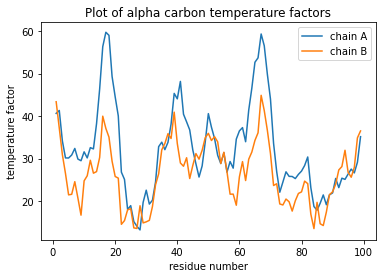

In [13]:
# We import pyplot from matplotlib
# Note the "inline" call is some jupyter magic to be able to show the plot
%matplotlib inline
from matplotlib import pyplot

# We pass the residue ids and alpha carbon temperature factors to pyplot's plot function
pyplot.plot(chainA_alphaC.resids, chainA_alphaC.atoms.tempfactors, label='chain A')
pyplot.plot(chainB_alphaC.resids, chainB_alphaC.atoms.tempfactors, label='chain B')

# Let's add some titles and legends
pyplot.title('Plot of alpha carbon temperature factors')
pyplot.xlabel('residue number')
pyplot.ylabel('temperature factor')
pyplot.legend()

# We call show() to show the plot
pyplot.show()

Here we have a plot with the blue line showing the alpha carbon temperature factors for chain A, and the yellow line for chain B. As we can see, the two chains don't completely agree, but there are particular patterns to observe. Specifically, we see very low temperature factors in the regions around residues 25 and 80. We also see defined peaks near residues 15 and 70.

Knowing this information can be quite useful when trying to work out what parts of your protein are moving and what might be influencing this motion.

That being said, looking purely at a plot does not help. What we can also do, is use NGLView to directly plot the temperature factors unto the cartoon representation of our protein. We do this in the following way:

In [14]:
# Create an NGL view based on our protein_residues selection
pdbview = nglview.show_mdanalysis(pdb)

# Set the interaction session interface type
pdbview.gui_style = 'ngl'

# Clear the representations and add a cartoon representation coloured by "beta factor"
pdbview.clear_representations()
pdbview.add_representation('cartoon', color='bfactor')
# We'll also show the ligand atoms as licorice
pdbview.add_representation('licorice', selection='MK1')


# Show the widget
pdbview

NGLWidget(gui_style='ngl')

Using the plot we created, can you work out what the colouring scheme of NGLView shows?

> Answer: Here we go from red being low beta factor regions, to blue being high ones. That is to say that bluer regions are more mobile.

Using these the plot and the NGLView representation, can you explain why there happens to be more mobile regions?

> Answer: think about which areas are more solvent exposed and therefore more likely to be in motion.

Looking at where the ligand is situated, are there any mobile residues that may influence binding?

> Answer: the loops composed of residues 49-52 are quite mobile as closed to the ligand, in fact previous [work by Hornak et al.](https://www.pnas.org/content/103/4/915) shows that these can spontaneously open and close. Doing a molecular dynamics simulation (as you will in the MD tutorial), might be helpful in elucidating how these loops move.